# 多项式回归


In [ ]:
import math
import torch
import numpy as np
from torch import nn



max_degree = 20
n_train, n_test = 100, 10
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])  # 真实模型参数
features = np.random.normal(size=(n_train + n_test, 1))  # 生成随机输入
np.random.shuffle(features)

# np.power: 计算输入数组元素的指定次幂
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # 生成多项式特征



In [ ]:
features

In [ ]:
poly_features

In [ ]:
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # 使用gamma函数对特征进行归一化，gamma(n)=(n-1)!

# np.dot: 矩阵点积
labels = np.dot(poly_features, true_w)  # 生成标签
labels += np.random.normal(scale=0.1, size=labels.shape)  # 添加噪声

In [ ]:
labels.shape

In [ ]:
poly_features.shape

In [ ]:
true_w.shape

In [ ]:
# 转换为张量
true_w,features,poly_features,labels = [torch.tensor(i, dtype=torch.float32) for i in [true_w,features,poly_features,labels]]

In [ ]:


from traintools import Accumulator, load_array, train_model, linear_reg


def evaluate_loss(net, data_iter, loss):
    """评估模型在数据迭代器上的损失"""
    metric = Accumulator(2)  # 累加器，用于存储总损失和样本数
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]  # 返回平均损失

def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    """训练模型"""
    loss = nn.MSELoss()  # 均方误差损失函数
    input_shape = train_features.shape[-1]  # 输入特征的维度
    net = nn.Sequential(nn.Linear(input_shape, 1,bias=False))  # 定义线性，不设置偏置，作为多项式零次存在
    batch_size = min(10, train_labels.shape[0])

    # train_labels.reshape(-1,1) 的意思是将 train_labels 转换为一个二维张量，其中-1表示该维度的大小由程序自动计算，以保证元素的总数不变，而 1 表示第二个维度的大小为 1。这样做的目的是将 train_labels 转换为一个列向量，使其能够与模型的输出进行比较和计算损失
    train_iter = load_array((train_features,train_labels.reshape(-1,1)),batch_size,is_train=True)
    test_iter = load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)

    trainer = torch.optim.SGD(net.parameters(), lr=0.01)

    train_model(net, train_iter, test_iter, loss, trainer,num_epochs=num_epochs,early_stopping_patience=999)

    print('weights:', net[0].weight.data.cpu().numpy().flatten())


In [ ]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:], num_epochs=400)

In [ ]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:], num_epochs=400)

In [ ]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

# 正则化技术

使用范数来度量权重的大小，L2范数（也称为权重衰减）是最常用的正则化方法之一。它通过在损失函数中添加权重的平方和来惩罚过大的权重，从而防止模型过拟合。

训练目标变为最小化 `loss + λ/2 * ||w||^2`，其中 `λ` 是正则化参数，控制正则化的强度。

In [6]:
import torch
from torch import nn
import traintools

n_train,n_test,num_inputs,batch_size = 20,100,200,5
true_w,true_b = torch.ones((num_inputs,1)) * 0.01, 0.05
train_data = traintools.synthetic_data(true_w, true_b, n_train)
test_data = traintools.synthetic_data(true_w, true_b, n_test)
train_iter = traintools.load_array(train_data, batch_size)
test_iter = traintools.load_array(test_data, batch_size, is_train=False)

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def l2_penalty(w):
    """L2范数正则化"""
    return torch.sum(w.pow(2)) / 2

In [11]:
def train(lambd):
    w,b = init_params()
    net = lambda X: traintools.linear_reg(X,w,b)
    # 将net转换为torch.nn.Module
    net = nn.Sequential(nn.Linear(num_inputs, 1, bias=True))
    net[0].weight.data = w.T  # 设置权重
    net[0].bias.data = b  # 设置偏置
    net[0].weight.requires_grad = True  # 设置权重需要梯度
    net[0].bias.requires_grad = True  # 设置偏置需要梯度

    loss = traintools.squared_loss
    num_epochs,lr = 100,0.03
    trainer = torch.optim.SGD([w, b], lr=lr)
    traintools.train_model(net, train_iter, test_iter, loss, trainer,
                           num_epochs=num_epochs, early_stopping=False)

    print('L2 norm of w:', torch.norm(w).item())


Epoch [1/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [2/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [3/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [4/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [5/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [6/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [7/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [8/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [9/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [10/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [11/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [12/100], Train Loss: 118.2137, Test Loss: 77.1251, Test Accuracy: 0.0000
Epoch [13/100], Train Loss: 118.2137, Test Loss: 

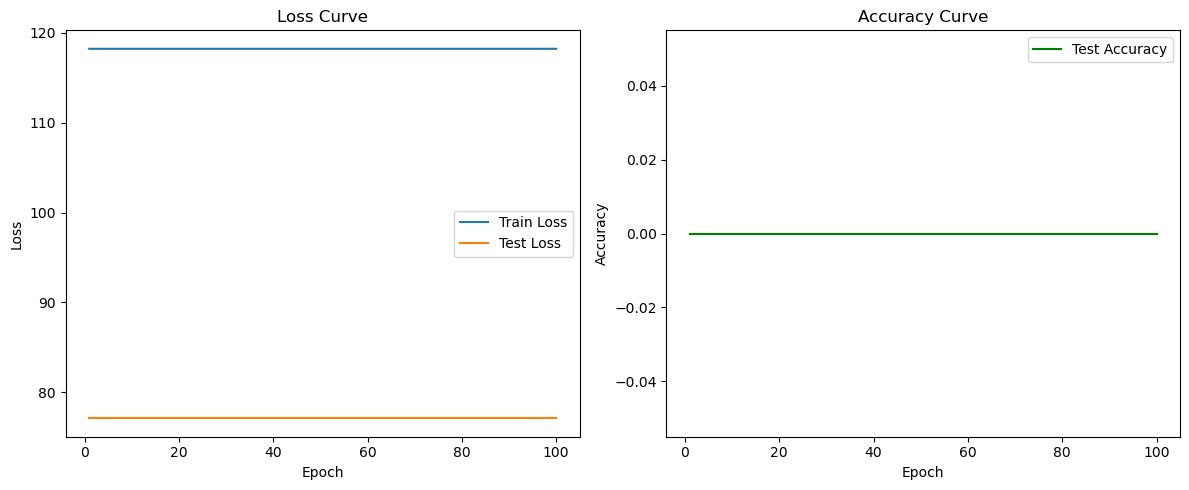

Model weights saved to: ./models\model_20250809_183507.pth
Full model saved to: ./models\model_20250809_183507.pt
Training log saved to: ./logs\train_log_20250809_183507.csv
L2 norm of w: 13.717931747436523


In [6]:
train(0)

Epoch [1/100], Train Loss: 628.6467, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [2/100], Train Loss: 628.6468, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [3/100], Train Loss: 628.6467, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [4/100], Train Loss: 628.6468, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [5/100], Train Loss: 628.6468, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [6/100], Train Loss: 628.6468, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [7/100], Train Loss: 628.6467, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [8/100], Train Loss: 628.6467, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [9/100], Train Loss: 628.6467, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [10/100], Train Loss: 628.6468, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [11/100], Train Loss: 628.6468, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [12/100], Train Loss: 628.6467, Test Loss: 113.3100, Test Accuracy: 0.0000
Epoch [13/100], Train Loss: 628.6467,

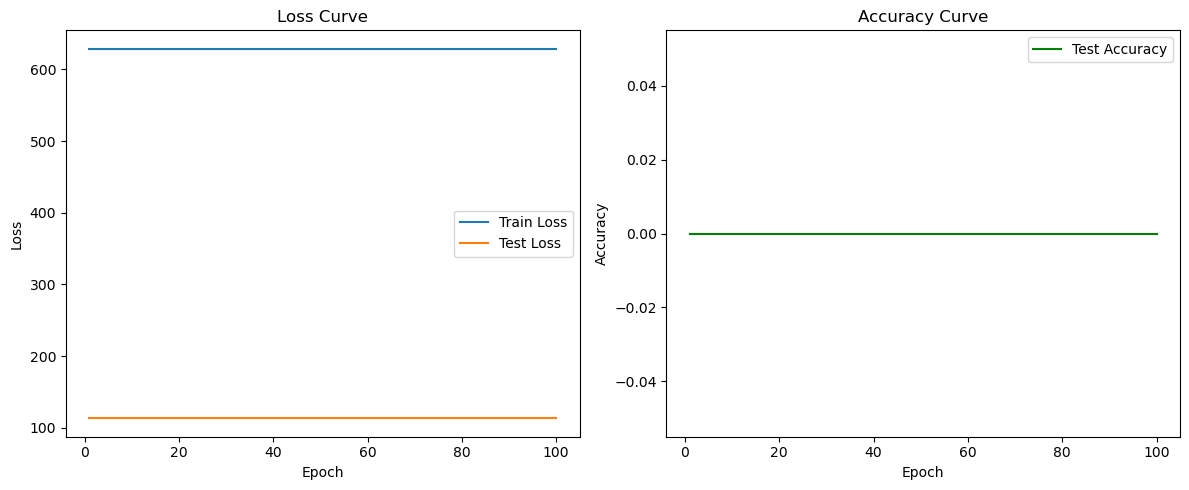

Model weights saved to: ./models\model_20250809_183517.pth
Full model saved to: ./models\model_20250809_183517.pt
Training log saved to: ./logs\train_log_20250809_183517.csv
L2 norm of w: 13.460301399230957


In [7]:
train(3)

# 权重衰减的简介实现

In [7]:
from torch import nn
import torch
import traintools
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1, bias=True))
    for param in net.parameters():
        param.requires_grad_(True)

    loss = nn.MSELoss(reduction='none')  # 使用均方误差损失函数
    num_epochs , lr = 100, 0.003

    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd},  # 权重衰减
        {'params': net[0].bias, 'weight_decay': 0}  # 偏置没有衰减
    ], lr=lr)

    traintools.train_model(net, train_iter, test_iter, loss, trainer,
                           num_epochs=num_epochs, )

    print('L2 norm of w:', torch.norm(net[0].weight.data).item())

Epoch [1/100], Train Loss: 0.2146, Test Loss: 0.3495, Test Accuracy: 0.0000
Epoch [2/100], Train Loss: 0.1206, Test Loss: 0.3448, Test Accuracy: 0.0000
Epoch [3/100], Train Loss: 0.0723, Test Loss: 0.3418, Test Accuracy: 0.0000
Epoch [4/100], Train Loss: 0.0441, Test Loss: 0.3398, Test Accuracy: 0.0000
Epoch [5/100], Train Loss: 0.0271, Test Loss: 0.3384, Test Accuracy: 0.0000
Epoch [6/100], Train Loss: 0.0166, Test Loss: 0.3374, Test Accuracy: 0.0000
Epoch [7/100], Train Loss: 0.0110, Test Loss: 0.3366, Test Accuracy: 0.0000
Epoch [8/100], Train Loss: 0.0070, Test Loss: 0.3360, Test Accuracy: 0.0000
Epoch [9/100], Train Loss: 0.0046, Test Loss: 0.3356, Test Accuracy: 0.0000
Epoch [10/100], Train Loss: 0.0030, Test Loss: 0.3352, Test Accuracy: 0.0000
Epoch [11/100], Train Loss: 0.0020, Test Loss: 0.3349, Test Accuracy: 0.0000
Epoch [12/100], Train Loss: 0.0013, Test Loss: 0.3347, Test Accuracy: 0.0000
Epoch [13/100], Train Loss: 0.0009, Test Loss: 0.3345, Test Accuracy: 0.0000
Epoch [1

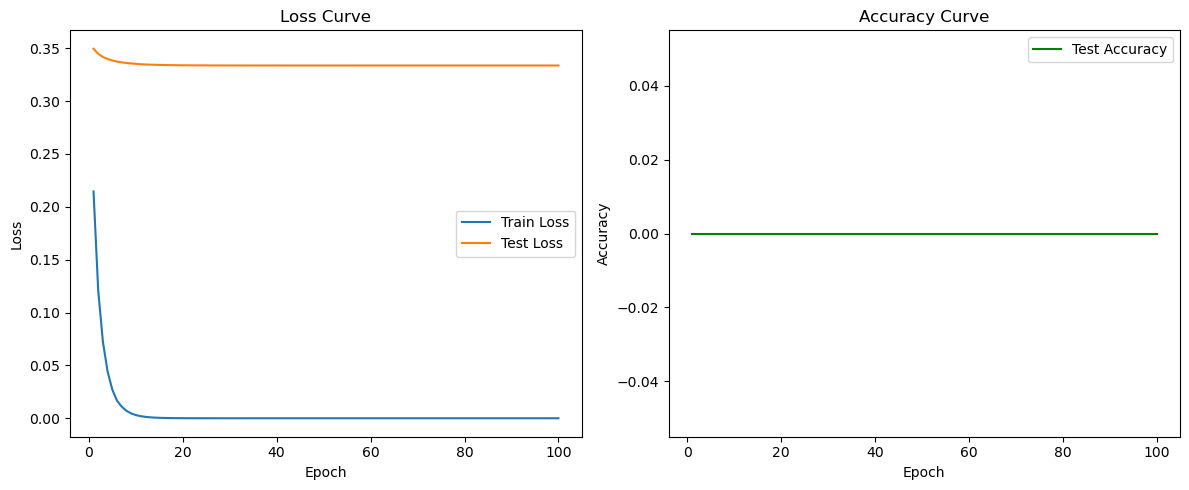

L2 norm of w: 0.5551874041557312


In [8]:
train_concise(0)

Epoch [1/100], Train Loss: 0.5874, Test Loss: 0.2842, Test Accuracy: 0.0000
Epoch [2/100], Train Loss: 0.2869, Test Loss: 0.2545, Test Accuracy: 0.0000
Epoch [3/100], Train Loss: 0.1465, Test Loss: 0.2324, Test Accuracy: 0.0000
Epoch [4/100], Train Loss: 0.0782, Test Loss: 0.2145, Test Accuracy: 0.0000
Epoch [5/100], Train Loss: 0.0437, Test Loss: 0.1992, Test Accuracy: 0.0000
Epoch [6/100], Train Loss: 0.0245, Test Loss: 0.1858, Test Accuracy: 0.0000
Epoch [7/100], Train Loss: 0.0144, Test Loss: 0.1738, Test Accuracy: 0.0000
Epoch [8/100], Train Loss: 0.0085, Test Loss: 0.1630, Test Accuracy: 0.0000
Epoch [9/100], Train Loss: 0.0052, Test Loss: 0.1530, Test Accuracy: 0.0000
Epoch [10/100], Train Loss: 0.0032, Test Loss: 0.1439, Test Accuracy: 0.0000
Epoch [11/100], Train Loss: 0.0021, Test Loss: 0.1354, Test Accuracy: 0.0000
Epoch [12/100], Train Loss: 0.0014, Test Loss: 0.1275, Test Accuracy: 0.0000
Epoch [13/100], Train Loss: 0.0009, Test Loss: 0.1203, Test Accuracy: 0.0000
Epoch [1

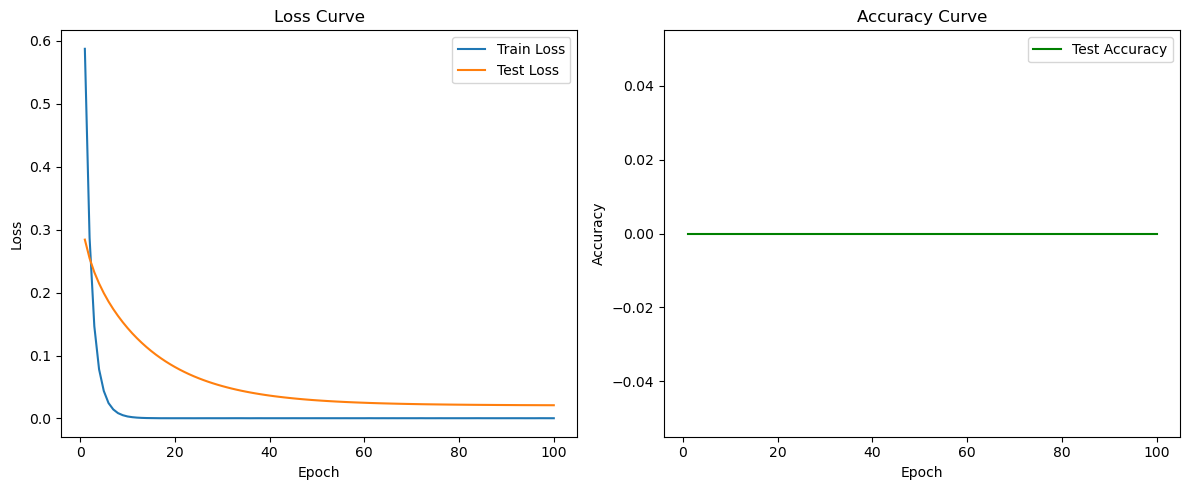

L2 norm of w: 0.044553063809871674


In [9]:
train_concise(3)

简单性
- 较小的维度
- 平滑性
  - 不应该对输入的微小变换敏感


In [2]:
import torch
from torch import nn

def dropout_layer(X, dropout):
    """Dropout层"""
    assert 0 <= dropout <= 1

    if dropout == 1:
        return torch.zeros_like(X)  # 如果dropout为1，返回全0张量
    if dropout == 0:
        return X  # 如果dropout为0，返回原始张量
    mask = (torch.rand(X.shape, device=X.device) > dropout).float()  # 生成随机掩码
    return mask * X / (1.0 - dropout) # 应用掩码并缩放输出

In [5]:
num_inputs,num_outputs,num_hiddens1,num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self,num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True):
        super(Net, self).__init__() # 调用父类的构造函数

        self.is_training = is_training  # 是否处于训练模式
        self.num_inputs = num_inputs
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()  # ReLU激活函数

    def forward(self, x):
        H1 = self.relu(self.lin1(x.reshape(-1, self.num_inputs)))
        if self.is_training:
            H1 = dropout_layer(H1, dropout1)  # 应用dropout
        H2 = self.relu(self.lin2(H1))
        if self.is_training:
            H2 = dropout_layer(H2, dropout2)  # 应用dropout
        out = self.lin3(H2)
        return out  # 返回输出




In [7]:
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True)
from traintools import train_model,load_data_fashion_mnist
num_epochs ,lr,batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()  # 交叉熵损失函数
train_iter ,test_iter = load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)

# train_model(net, train_iter, test_iter, loss, trainer,num_epochs=num_epochs, early_stopping=False)


Epoch [1/10], Train Loss: 0.9777, Test Loss: 0.6358, Test Accuracy: 0.7666
Epoch [2/10], Train Loss: 0.5947, Test Loss: 0.5618, Test Accuracy: 0.7754
Epoch [3/10], Train Loss: 0.5280, Test Loss: 0.5507, Test Accuracy: 0.7801
Epoch [4/10], Train Loss: 0.4936, Test Loss: 0.4784, Test Accuracy: 0.8179
Epoch [5/10], Train Loss: 0.4767, Test Loss: 0.4459, Test Accuracy: 0.8308
Epoch [6/10], Train Loss: 0.4677, Test Loss: 0.4532, Test Accuracy: 0.8324
Epoch [7/10], Train Loss: 0.4562, Test Loss: 0.4608, Test Accuracy: 0.8316
Epoch [8/10], Train Loss: 0.4447, Test Loss: 0.4870, Test Accuracy: 0.8201
Epoch [9/10], Train Loss: 0.4416, Test Loss: 0.4300, Test Accuracy: 0.8433
Epoch [10/10], Train Loss: 0.4334, Test Loss: 0.4025, Test Accuracy: 0.8529


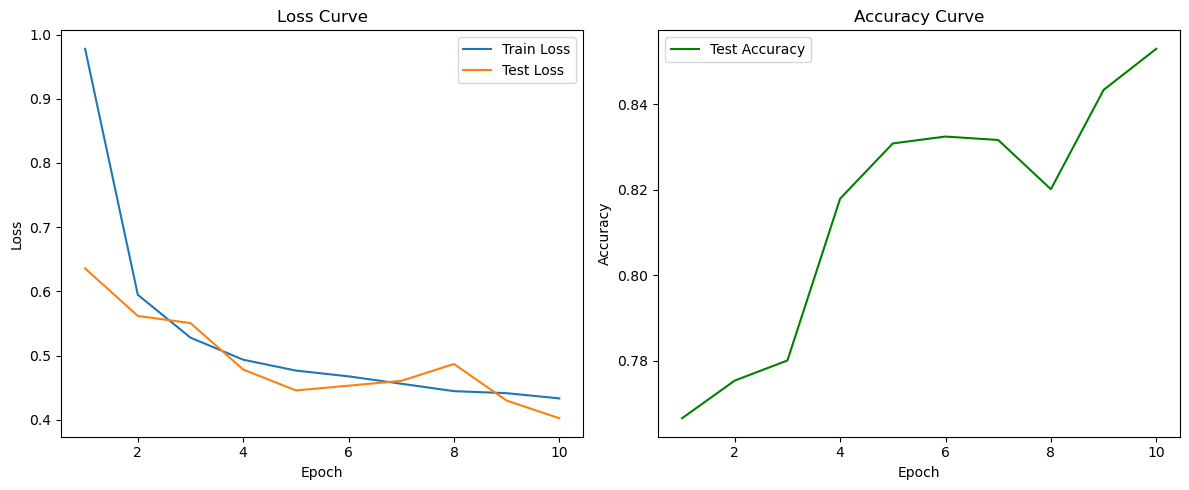

In [8]:
dropout1 = 0.5
dropout2 = 0.2
net = nn.Sequential(
    nn.Flatten(),  # 展平输入
    nn.Linear(784, 256),
    nn.ReLU(),
    # 添加第一个Dropout层
    nn.Dropout(dropout1),
    nn.Linear(256, 256),
    nn.ReLU(),
    # 添加第二个Dropout层
    nn.Dropout(dropout2),
    nn.Linear(256, 10)

)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.1)  # 初始化权重

net.apply(init_weights)

# 应用权重衰减
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.001)
train_model(net, train_iter, test_iter, loss, trainer,
            num_epochs=num_epochs, early_stopping=False)



